In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split


In [2]:
path_to_data = "C:\\Users\\ryanz\\Documents\\CS528\\project\\real_time_svm\\data"

data = {}
words = ["play", "pause", "skip", 'rewind']

for filename in os.listdir(path_to_data):
    df = pd.read_csv(path_to_data + "\\" + filename)
    df = df.reset_index().rename(columns={'index': 'Sample Num'})

    for word in words:
        if word in filename:
            if word not in data:
                data[word] = {filename: df}
            else:
                data[word][filename] = df
                
    

    


In [3]:

max_length = 0
for word in data:
    for filename in data[word]:
        df = data[word][filename]
        max_length = max(max_length, df.shape[0])

X = []
y = []
scaler = MinMaxScaler()
target_length = max_length

for word in data:
    for filename in data[word]:
        df = data[word][filename]
        vals = df[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']].values.astype(np.float32)
        
        vals = scaler.fit_transform(vals)
        
        #pad arrays with zeros
        if vals.shape[0] < target_length:
            padding = np.zeros((target_length - vals.shape[0], vals.shape[1]))
            vals = np.vstack((vals, padding))
        else:
            vals = vals[:target_length, :]
        
        X.append(vals.flatten())
        y.append(word)

X = np.array(X)
y = np.array(y)


In [4]:
def train_svm(X, y):
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    le = LabelEncoder()
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        
        svm_classifier = SVC(kernel='rbf')
        svm_classifier.fit(X_train, y_train)
        
        y_pred = svm_classifier.predict(X_test)
        
        y_test_encoded = le.fit_transform(y_test)
        y_pred_encoded = le.transform(y_pred)
        
        
        accuracies.append(accuracy_score(y_test_encoded, y_pred_encoded))
        precisions.append(precision_score(y_test_encoded, y_pred_encoded, average='macro'))
        recalls.append(recall_score(y_test_encoded, y_pred_encoded, average='macro'))
        f1s.append(f1_score(y_test_encoded, y_pred_encoded, average='macro'))
        
        
        
        
        print(f"Fold {i} accuracy: {accuracy_score(y_test_encoded, y_pred_encoded)}")
        
        conf_matrix = confusion_matrix(y_test, y_pred)
        sns.heatmap(conf_matrix, annot=True, cmap="Blues", xticklabels=words, yticklabels=words)
        plt.title('train')
        plt.xlabel('pred')
        plt.ylabel('actual')
        plt.show()
        
    return accuracies, precisions, recalls, f1s

### SVM

Fold 0 accuracy: 1.0


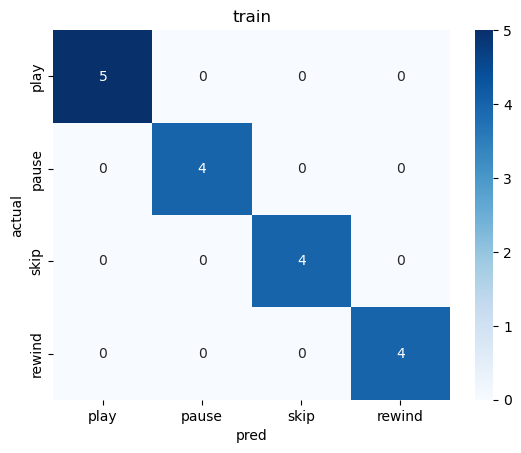

Fold 1 accuracy: 1.0


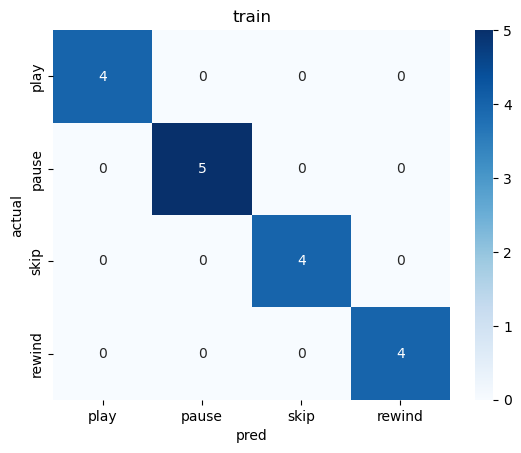

Fold 2 accuracy: 1.0


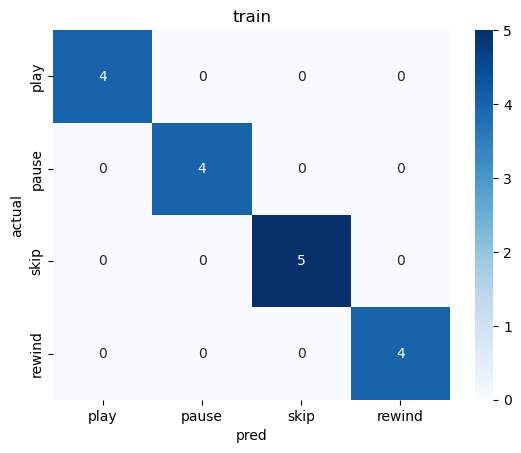

Fold 3 accuracy: 1.0


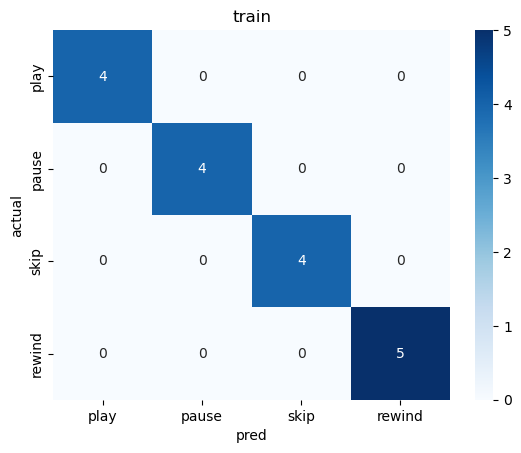

Fold 4 accuracy: 0.9375


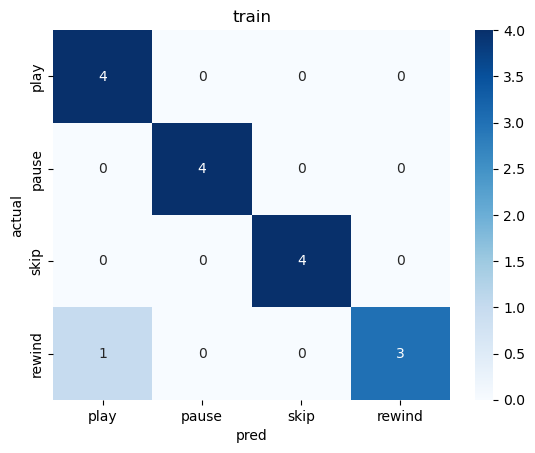

Average Accuracy Score: 0.9875
Average Precision Score: 0.99
Average Recall Score: 0.9875
Average F1 Score: 0.9873015873015873


In [5]:
# Perform training and testing with SVM
accuracies, precisions, recalls, f1s = train_svm(X, y)

avgAcc = np.mean(accuracies)
avgPrec = np.mean(precisions)
avgRec = np.mean(recalls)
avgF1 = np.mean(f1s)

print(f"Average Accuracy Score: {avgAcc}")
print(f"Average Precision Score: {avgPrec}")
print(f"Average Recall Score: {avgRec}")
print(f"Average F1 Score: {avgF1}")
